In [1]:
import uproot
import numpy as np
import sys
import os
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import itertools
import awkward as ak
from scipy.optimize import curve_fit
%matplotlib inline

In [2]:
file = uproot.open("tracking_losses_ntuple_Bd2KstEE.root:PrDebugTrackingLosses.PrDebugTrackingTool/Tuple;1")
#file = uproot.open("tracking_losses_ntuple_Dst0ToD0EE.root:PrDebugTrackingLosses.PrDebugTrackingTool/Tuple;1")


#selektiere nur elektronen von B->K*ee und nur solche mit einem momentum von ueber 5 GeV 
allcolumns = file.arrays()
found = allcolumns[(allcolumns.isElectron) & (~allcolumns.lost) & (allcolumns.fromSignal) & (allcolumns.p > 5e3)] #B: 9056
lost = allcolumns[(allcolumns.isElectron) & (allcolumns.lost) & (allcolumns.fromSignal) & (allcolumns.p > 5e3)] #B: 1466

#ak.num(found, axis=0)
#ak.count(found, axis=None)


In [3]:
def t_eff(found, lost):
    sel = found["energy"]
    des = lost["energy"]
    return ak.count(sel,axis=None)/(ak.count(sel,axis=None)+ak.count(des,axis=None))

t_eff(found, lost)

0.8606728758791105

In [4]:
#finden wir die elektronen die keine bremsstrahlung gemacht haben mit hoher effizienz?
nobrem_found = found[found["brem_photons_pe_length"]==0]
nobrem_lost = lost[lost["brem_photons_pe_length"]==0]

"""
die effizienz mit der wir elektronen finden, die keine bremsstrahlung gemacht haben, ist gut mit 0.9688.
allerdings haben wir hier nur sehr wenige teilchen (<100)
"""

t_eff(nobrem_found, nobrem_lost)


0.96875

In [5]:
#wie viel energie relativ zur anfangsenergie verlieren die elektronen durch bremstrahlung und hat das einen einfluss darauf ob wir sie finden oder nicht?
brem_found = found[found["brem_photons_pe_length"]!=0]
energy_found = ak.to_numpy(brem_found["energy"])
eph_found = ak.to_numpy(ak.sum(brem_found["brem_photons_pe"], axis=-1, keepdims=False))
energyloss_found = eph_found/energy_found


brem_lost = lost[lost["brem_photons_pe_length"]!=0]
energy_lost = ak.to_numpy(brem_lost["energy"])
eph_lost = ak.to_numpy(ak.sum(brem_lost["brem_photons_pe"], axis=-1, keepdims=False))
energyloss_lost = eph_lost/energy_lost

t_eff(brem_found,brem_lost)

0.8603431839847474

In [6]:
mean_energyloss_found = ak.mean(energyloss_found)
mean_energyloss_lost = ak.mean(energyloss_lost)
print("mean energyloss relative to initial energy (found): ", mean_energyloss_found)
print("mean energyloss relative to initial energy (lost): ", mean_energyloss_lost)

mean energyloss relative to initial energy (found):  0.6475128752780828
mean energyloss relative to initial energy (lost):  0.8241268441538472


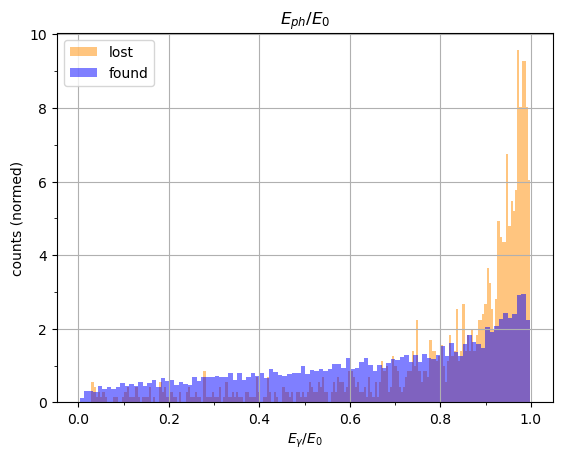

In [7]:
plt.hist(energyloss_lost, bins=200, density=True, alpha=0.5, histtype='bar', color="darkorange", label="lost")
plt.hist(energyloss_found, bins=100, density=True, alpha=0.5, histtype='bar', color="blue", label="found")
plt.xticks(np.arange(0,1.1,0.1), minor=True,)
plt.yticks(np.arange(0,10,1), minor=True)
plt.xlabel(r"$E_\gamma/E_0$")
plt.ylabel("counts (normed)")
plt.title(r'$E_{ph}/E_0$')
plt.legend()
plt.grid()

"""
found: elektronen verlieren durchschnittlich 0.65 ihrer anfangsenergie durch bremsstrahlung
lost: elektronen verlieren durchschnittlich 0.82 ihrer anfangsenergie durch bremsstrahlung

-> wir können sofort erkennen, dass verlorene elektronen im schnitt mehr energie durch bremsstrahlung verlieren als gefundene, 
aber auch die rate der gefundenen elektronen steigt für raten nahe 1, wenn auch wesentlich schwächer als für verlorene elektronen.
die meisten verlorenen elektronen verlieren >0.8 ihrer anfangsenergie.
"""

plt.show()

In [8]:
#ist die shape der teilspur im scifi anders? (koenntest du zum beispiel durch vergleich der verteilungen der fit parameter studieren,
#in meiner thesis findest du das fitmodell -- ist einfach ein polynom dritten grades)
z_ref=8520 #mm

def scifi_track(z, a, b, c, d):
    return a + b*(z-z_ref) + c*(z-z_ref)**2 + d*(z-z_ref)**3

def z_mag(xv, zv, tx, a, b):
    """ optical centre of the magnet is defined as the intersection between the trajectory tangents before and after the magnet

    Args:
        xv (double): velo x track
        zv (double): velo z track
        tx (double): velo x slope
        a (double): ax parameter of track fit
        b (double): bx parameter of track fit

    Returns:
        double: z_mag
    """
    return (xv-tx*zv-a+b*z_ref)/(b-tx)

In [9]:
scifi_found = found[found["scifi_hit_pos_x_length"]>3]
scifi_lost = lost[lost["scifi_hit_pos_x_length"]>3]

scifi_x_found = scifi_found["scifi_hit_pos_x"]
scifi_z_found = scifi_found["scifi_hit_pos_z"]

tx_found = scifi_found["velo_track_tx"]

scifi_x_lost = scifi_lost["scifi_hit_pos_x"]
scifi_z_lost = scifi_lost["scifi_hit_pos_z"]

tx_lost = scifi_lost["velo_track_tx"]

xv_found = scifi_found["velo_track_x"]
zv_found = scifi_found["velo_track_z"]

xv_lost = scifi_lost["velo_track_x"]
zv_lost = scifi_lost["velo_track_z"]



#ak.num(scifi_found["energy"], axis=0)
#scifi_found.snapshot()

In [10]:
#tx_lost.show()

In [11]:
scifi_fitpars_found = ak.ArrayBuilder()

for i in range(0,ak.num(scifi_found["energy"], axis=0)):
    popt, pcov = curve_fit(scifi_track,ak.to_numpy(scifi_z_found[i,:]),ak.to_numpy(scifi_x_found[i,:]))
    scifi_fitpars_found.begin_list()
    scifi_fitpars_found.real(popt[0])
    scifi_fitpars_found.real(popt[1])
    scifi_fitpars_found.real(popt[2])
    scifi_fitpars_found.real(popt[3])
    scifi_fitpars_found.end_list()

scifi_fitpars_lost = ak.ArrayBuilder()

for i in range(0,ak.num(scifi_lost["energy"], axis=0)):
    popt, pcov = curve_fit(scifi_track,ak.to_numpy(scifi_z_lost[i,:]),ak.to_numpy(scifi_x_lost[i,:]))
    scifi_fitpars_lost.begin_list()
    scifi_fitpars_lost.real(popt[0])
    scifi_fitpars_lost.real(popt[1])
    scifi_fitpars_lost.real(popt[2])
    scifi_fitpars_lost.real(popt[3])
    scifi_fitpars_lost.end_list()


scifi_fitpars_lost = scifi_fitpars_lost.to_numpy()
scifi_fitpars_found = scifi_fitpars_found.to_numpy()



dtx_found = scifi_fitpars_found[:,1] - tx_found
dtx_lost = scifi_fitpars_lost[:,1] - tx_lost


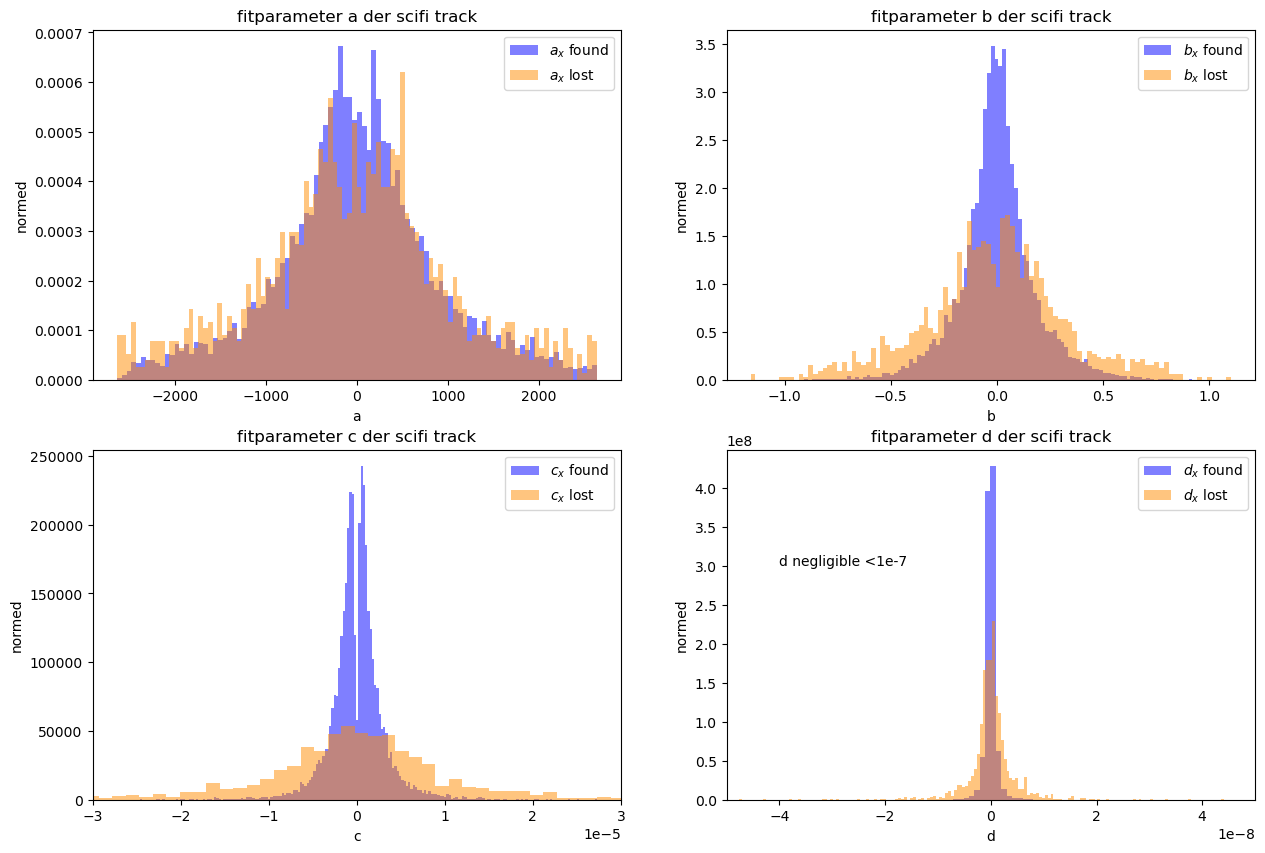

In [12]:
fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(nrows=2, ncols=2, figsize=(15,10))

ax0.hist(scifi_fitpars_found[:,0], bins=100, density=True, alpha=0.5, histtype='bar', color="blue", label=r"$a_x$ found")
ax0.hist(scifi_fitpars_lost[:,0], bins=100, density=True, alpha=0.5, histtype='bar', color="darkorange", label=r"$a_x$ lost")
ax0.set_xlabel("a")
ax0.set_ylabel("normed")
ax0.set_title("fitparameter a der scifi track")
ax0.legend()

ax1.hist(scifi_fitpars_found[:,1], bins=100, density=True, alpha=0.5, histtype='bar', color="blue", label=r"$b_x$ found")
ax1.hist(scifi_fitpars_lost[:,1], bins=100, density=True, alpha=0.5, histtype='bar', color="darkorange", label=r"$b_x$ lost")
ax1.set_xlabel("b")
ax1.set_ylabel("normed")
ax1.set_title("fitparameter b der scifi track")
ax1.legend()

ax2.hist(scifi_fitpars_found[:,2], bins=500, density=True, alpha=0.5, histtype='bar', color="blue", label=r"$c_x$ found")
ax2.hist(scifi_fitpars_lost[:,2], bins=500, density=True, alpha=0.5, histtype='bar', color="darkorange", label=r"$c_x$ lost")
ax2.set_xlim([-3e-5,3e-5])
ax2.set_xticks(np.arange(-3e-5,3.5e-5,1e-5),minor=False)
ax2.set_xlabel("c")
ax2.set_ylabel("normed")
ax2.set_title("fitparameter c der scifi track")
ax2.legend()

ax3.hist(scifi_fitpars_found[:,3], bins=500, density=True, alpha=0.5, histtype='bar', color="blue", label=r"$d_x$ found")
ax3.hist(scifi_fitpars_lost[:,3], bins=500, density=True, alpha=0.5, histtype='bar', color="darkorange", label=r"$d_x$ lost")
ax3.set(xlim=(-5e-8,5e-8))
ax3.text(-4e-8,3e8,"d negligible <1e-7")
ax3.set_xlabel("d")
ax3.set_ylabel("normed")
ax3.set_title("fitparameter d der scifi track")
ax3.legend()

"""
a_x: virtual hit on the reference plane
"""

plt.show()

In [13]:
np.min(scifi_fitpars_found[:,3])

-4.6785491318157854e-07

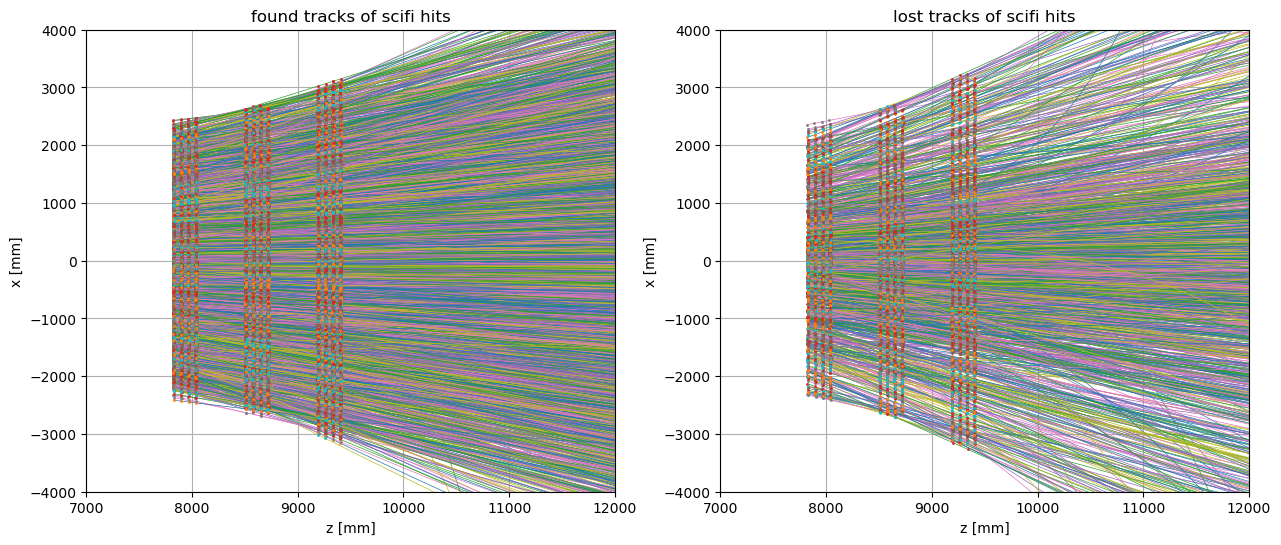

In [14]:
fig, ((ax0, ax1)) = plt.subplots(nrows=1, ncols=2, figsize=(15,6))

for i in range(0,ak.num(scifi_found["energy"], axis=0)):
    z_coord = np.linspace(scifi_z_found[i,0],12000,300)
    fit = scifi_track(z_coord, *scifi_fitpars_found[i])
    ax0.plot(z_coord, fit, "-", lw=0.5)
    ax0.errorbar(ak.to_numpy(scifi_z_found[i,:]),ak.to_numpy(scifi_x_found[i,:]),fmt=".",ms=2)

#ax0.legend()
ax0.set_xlabel("z [mm]")
ax0.set_ylabel("x [mm]")
ax0.set_title("found tracks of scifi hits")
ax0.set(xlim=(7e3,12000), ylim=(-4000,4000))
ax0.grid()

for i in range(0,ak.num(scifi_lost["energy"], axis=0)):
    z_coord = np.linspace(scifi_z_lost[i,0],12000,300)
    fit = scifi_track(z_coord, *scifi_fitpars_lost[i])
    ax1.plot(z_coord, fit, "-", lw=0.5)
    ax1.errorbar(ak.to_numpy(scifi_z_lost[i,:]),ak.to_numpy(scifi_x_lost[i,:]),fmt=".",ms=2)

#ax1.legend()
ax1.set_xlabel("z [mm]")
ax1.set_ylabel("x [mm]")
ax1.set_title("lost tracks of scifi hits")
ax1.set(xlim=(7e3,12000), ylim=(-4000,4000))
ax1.grid()

plt.show()

In [15]:
#vergleich der zmag werte
zmag_found = z_mag(xv_found, zv_found, tx_found, scifi_fitpars_found[:,0], scifi_fitpars_found[:,1])
zmag_lost = z_mag(xv_lost, zv_lost, tx_lost, scifi_fitpars_lost[:,0], scifi_fitpars_lost[:,1])
zmag_lost = zmag_lost[~np.isnan(zmag_lost)]
#zmag_lost.show()



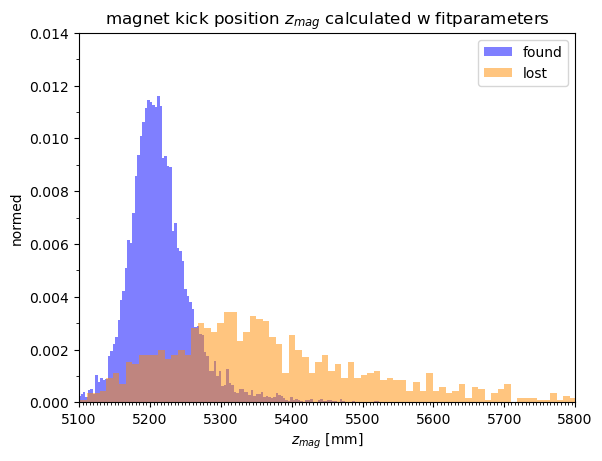

In [16]:
plt.hist(zmag_found, bins=5000, density=True, alpha=0.5, histtype='bar', color="blue", label="found")
plt.hist(zmag_lost, bins=300, density=True, alpha=0.5, histtype="bar",color="darkorange", label="lost")
plt.xlabel("$z_{mag}$ [mm]")
plt.ylabel("normed")
plt.title("magnet kick position $z_{mag}$ calculated w fitparameters")
plt.legend()
plt.xticks(np.arange(5100,5800,5), minor=True)
plt.yticks(np.arange(0,0.015,0.001), minor=True)
plt.xlim(5100,5800)

"""
wir können einen radikalen unterschied für den z_mag wert erkennen, zwischen den found and lost elektronen.
"""

plt.show()

{'all_endvtx_types_length': 12,
 'all_endvtx_types': [101.0,
  101.0,
  101.0,
  101.0,
  104.0,
  101.0,
  101.0,
  101.0,
  101.0,
  101.0,
  101.0,
  110.0],
 'all_endvtx_x_length': 12,
 'all_endvtx_x': [-3.31820011138916,
  -3.4500999450683594,
  -20.166799545288086,
  -120.83049774169922,
  -150.31619262695312,
  -155.7082977294922,
  -187.58470153808594,
  -195.8394012451172,
  -196.60830688476562,
  -196.72889709472656,
  -197.48280334472656,
  -202.9868927001953],
 'all_endvtx_y_length': 12,
 'all_endvtx_y': [-4.850500106811523,
  -5.047299861907959,
  -29.993200302124023,
  -196.2998046875,
  -270.5392150878906,
  -285.7712097167969,
  -380.3049011230469,
  -405.302490234375,
  -407.66009521484375,
  -408.0318908691406,
  -410.36138916015625,
  -434.51611328125],
 'all_endvtx_z_length': 12,
 'all_endvtx_z': [184.35940551757812,
  190.19970703125,
  929.2517700195312,
  5855.25390625,
  8055.12451171875,
  8506.958984375,
  11310.3232421875,
  12051.8232421875,
  12121.90332031